# Step 0: Loading the data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
validation_file="./data/valid.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Data Loaded")

Data Loaded


# Installing Modules

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

2025-12-02 02:17:12.622258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764638232.665057   32715 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764638232.680496   32715 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764638232.774393   32715 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764638232.774463   32715 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764638232.774467   32715 computation_placer.cc:177] computation placer alr

# Step 1 : Data Summary and Exploration

In [3]:
from scipy.ndimage import rotate


def adjust_brightness(img, factor):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)


def add_noise(img, mean=0, std=10):
    noise = np.random.normal(mean, std, img.shape)
    noisy = img + noise
    return np.clip(noisy, 0, 255).astype(np.uint8)



def random_augment(img):
    #if np.random.rand() < 0.5:
    #    img = np.fliplr(img)
    #if np.random.rand() < 0.5:
    #    img = np.flipud(img)
    if np.random.rand() < 0.3:
        img = rotate(img, angle=np.random.uniform(-20, 20), reshape=False)
    if np.random.rand() < 0.5:
        img = adjust_brightness(img, np.random.uniform(0.7, 1.3))
    if np.random.rand() < 0.5:
        img = add_noise(img, std=np.random.uniform(5, 20))
    return np.clip(img, 0, 255).astype(np.uint8)

X_aug, y_aug = [], []

for steps, (image, label) in enumerate(zip(X_train, y_train), 1):
    X_aug.append(random_augment(image))
    y_aug.append(label)

X_aug = np.array(X_aug, np.uint8)
y_aug = np.array(y_aug, np.uint8)

X_train = np.concatenate((X_train, X_aug), axis=0)
y_train = np.concatenate((y_train, y_aug), axis=0)

In [4]:
n_train = len(X_train)

n_valid=len(X_valid)

n_test = len(X_test)

image_shape = X_train[0].shape

class_data = pd.read_csv("signnames.csv")

n_classes = len(class_data["SignName"])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 69598
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Plotting data

In [5]:
print(class_data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

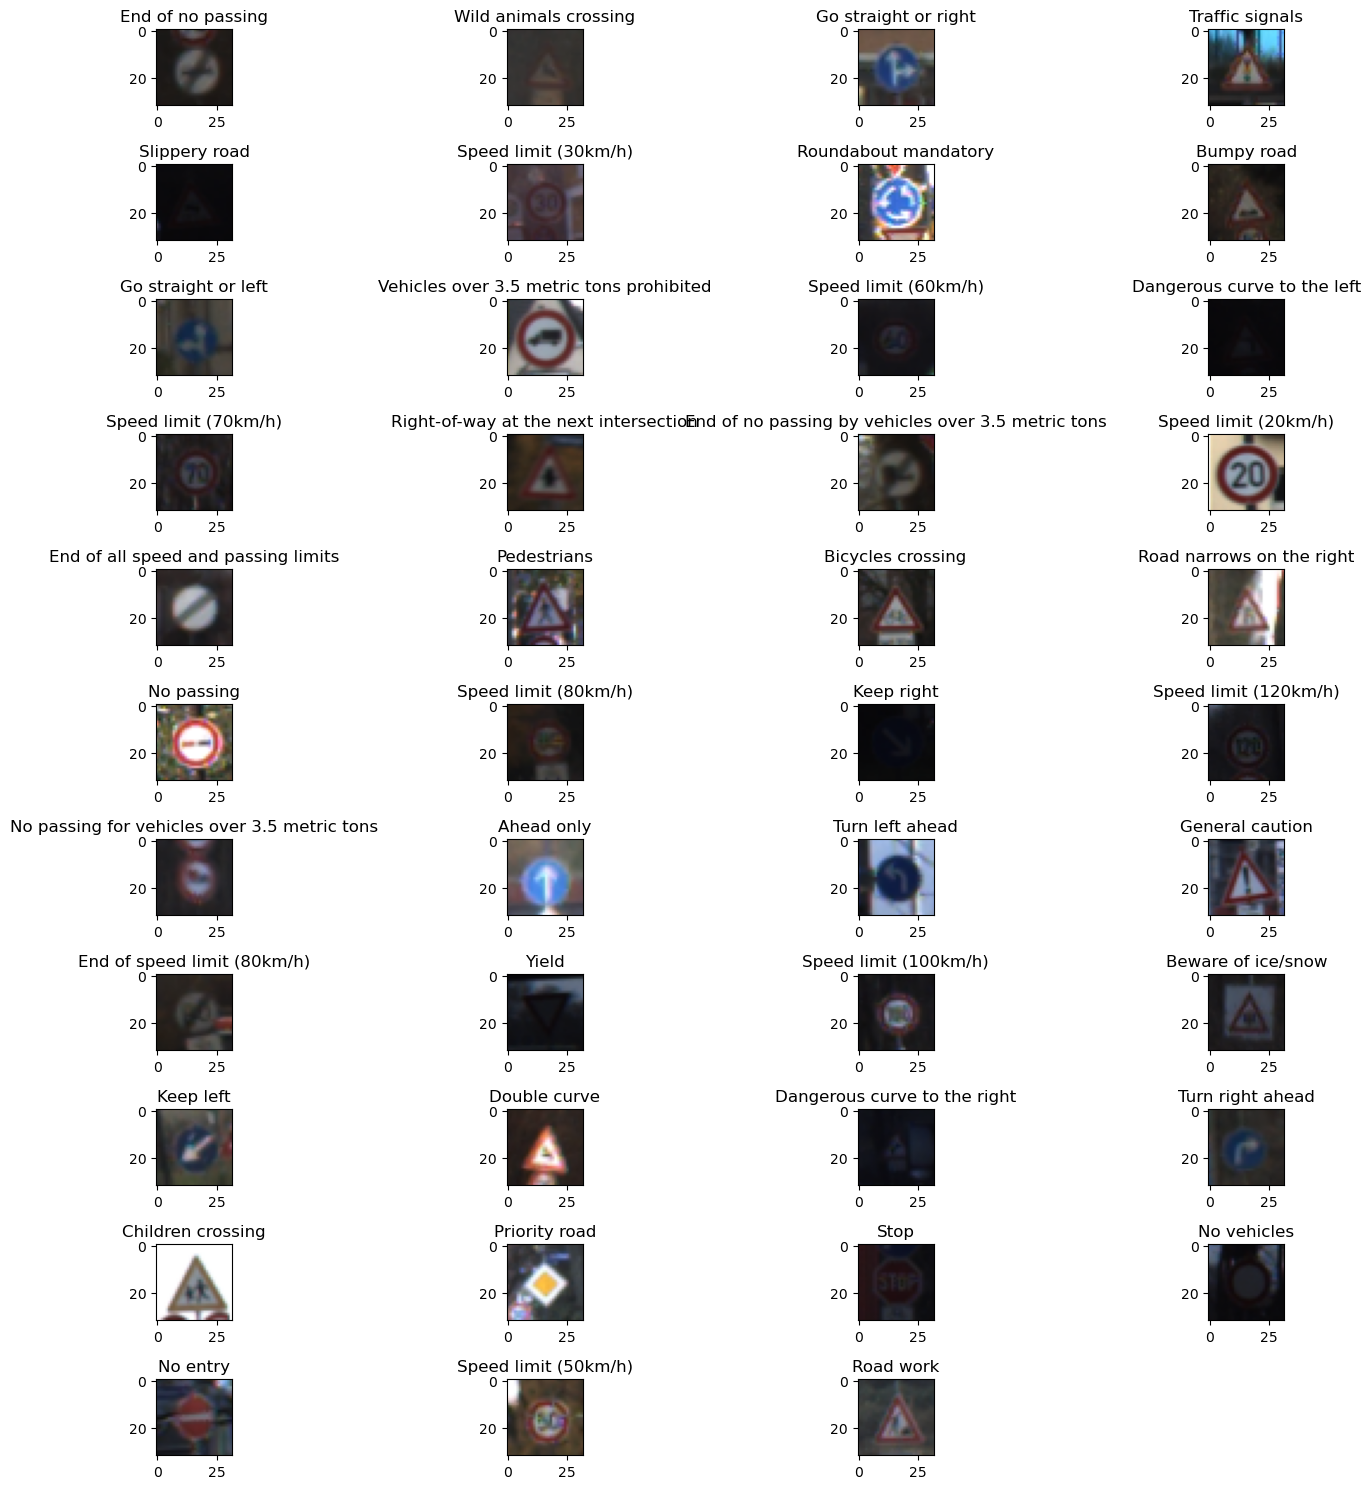

In [6]:
import matplotlib.pyplot as plt


unique_labels = np.unique(y_train)
shown_labels = set()
n_unique = len(unique_labels)
n_cols = 4
n_rows = int(np.ceil(n_unique / n_cols))
plt.figure(figsize=(15, 15))


for steps, (img, im_label) in enumerate(zip(X_train, y_train), 1):
    if im_label not in shown_labels:
        plt.subplot(n_rows, n_cols, len(shown_labels) + 1)
        plt.imshow(img)
        plt.title(class_data.iloc[im_label, 1])
        shown_labels.add(im_label)
    if len(shown_labels) == n_unique:
        break

plt.tight_layout()
plt.show()
%matplotlib inline

## Train dataset classes count

In [7]:
from pprint import pp



def classes_count(y):
    classes_dict = dict()
    for label in shown_labels:
        classes_dict[class_data.iloc[label, 1]] = 0
    for steps, im_label in enumerate(y):
        classes_dict[class_data.iloc[im_label, 1]] += 1
    return classes_dict

train_count = classes_count(y_train)

pp(train_count)

{'Speed limit (20km/h)': 360,
 'Speed limit (30km/h)': 3960,
 'Speed limit (50km/h)': 4020,
 'Speed limit (60km/h)': 2520,
 'Speed limit (70km/h)': 3540,
 'Speed limit (80km/h)': 3300,
 'End of speed limit (80km/h)': 720,
 'Speed limit (100km/h)': 2580,
 'Speed limit (120km/h)': 2520,
 'No passing': 2640,
 'No passing for vehicles over 3.5 metric tons': 3600,
 'Right-of-way at the next intersection': 2340,
 'Priority road': 3780,
 'Yield': 3840,
 'Stop': 1380,
 'No vehicles': 1080,
 'Vehicles over 3.5 metric tons prohibited': 720,
 'No entry': 1980,
 'General caution': 2160,
 'Dangerous curve to the left': 360,
 'Dangerous curve to the right': 600,
 'Double curve': 540,
 'Bumpy road': 660,
 'Slippery road': 900,
 'Road narrows on the right': 480,
 'Road work': 2700,
 'Traffic signals': 1080,
 'Pedestrians': 420,
 'Children crossing': 960,
 'Bicycles crossing': 480,
 'Beware of ice/snow': 780,
 'Wild animals crossing': 1380,
 'End of all speed and passing limits': 420,
 'Turn right ahea

## Validation dataset classes count

In [8]:
valid_count = classes_count(y_valid)

pp(valid_count)

{'Speed limit (20km/h)': 30,
 'Speed limit (30km/h)': 240,
 'Speed limit (50km/h)': 240,
 'Speed limit (60km/h)': 150,
 'Speed limit (70km/h)': 210,
 'Speed limit (80km/h)': 210,
 'End of speed limit (80km/h)': 60,
 'Speed limit (100km/h)': 150,
 'Speed limit (120km/h)': 150,
 'No passing': 150,
 'No passing for vehicles over 3.5 metric tons': 210,
 'Right-of-way at the next intersection': 150,
 'Priority road': 210,
 'Yield': 240,
 'Stop': 90,
 'No vehicles': 90,
 'Vehicles over 3.5 metric tons prohibited': 60,
 'No entry': 120,
 'General caution': 120,
 'Dangerous curve to the left': 30,
 'Dangerous curve to the right': 60,
 'Double curve': 60,
 'Bumpy road': 60,
 'Slippery road': 60,
 'Road narrows on the right': 30,
 'Road work': 150,
 'Traffic signals': 60,
 'Pedestrians': 30,
 'Children crossing': 60,
 'Bicycles crossing': 30,
 'Beware of ice/snow': 60,
 'Wild animals crossing': 90,
 'End of all speed and passing limits': 30,
 'Turn right ahead': 90,
 'Turn left ahead': 60,
 'Ahe

## Test dataset classes count

In [9]:
test_count = classes_count(y_test)

pp(test_count)

{'Speed limit (20km/h)': 60,
 'Speed limit (30km/h)': 720,
 'Speed limit (50km/h)': 750,
 'Speed limit (60km/h)': 450,
 'Speed limit (70km/h)': 660,
 'Speed limit (80km/h)': 630,
 'End of speed limit (80km/h)': 150,
 'Speed limit (100km/h)': 450,
 'Speed limit (120km/h)': 450,
 'No passing': 480,
 'No passing for vehicles over 3.5 metric tons': 660,
 'Right-of-way at the next intersection': 420,
 'Priority road': 690,
 'Yield': 720,
 'Stop': 270,
 'No vehicles': 210,
 'Vehicles over 3.5 metric tons prohibited': 150,
 'No entry': 360,
 'General caution': 390,
 'Dangerous curve to the left': 60,
 'Dangerous curve to the right': 90,
 'Double curve': 90,
 'Bumpy road': 120,
 'Slippery road': 150,
 'Road narrows on the right': 90,
 'Road work': 480,
 'Traffic signals': 180,
 'Pedestrians': 60,
 'Children crossing': 150,
 'Bicycles crossing': 90,
 'Beware of ice/snow': 150,
 'Wild animals crossing': 270,
 'End of all speed and passing limits': 60,
 'Turn right ahead': 210,
 'Turn left ahead'

## Data Visualizetion

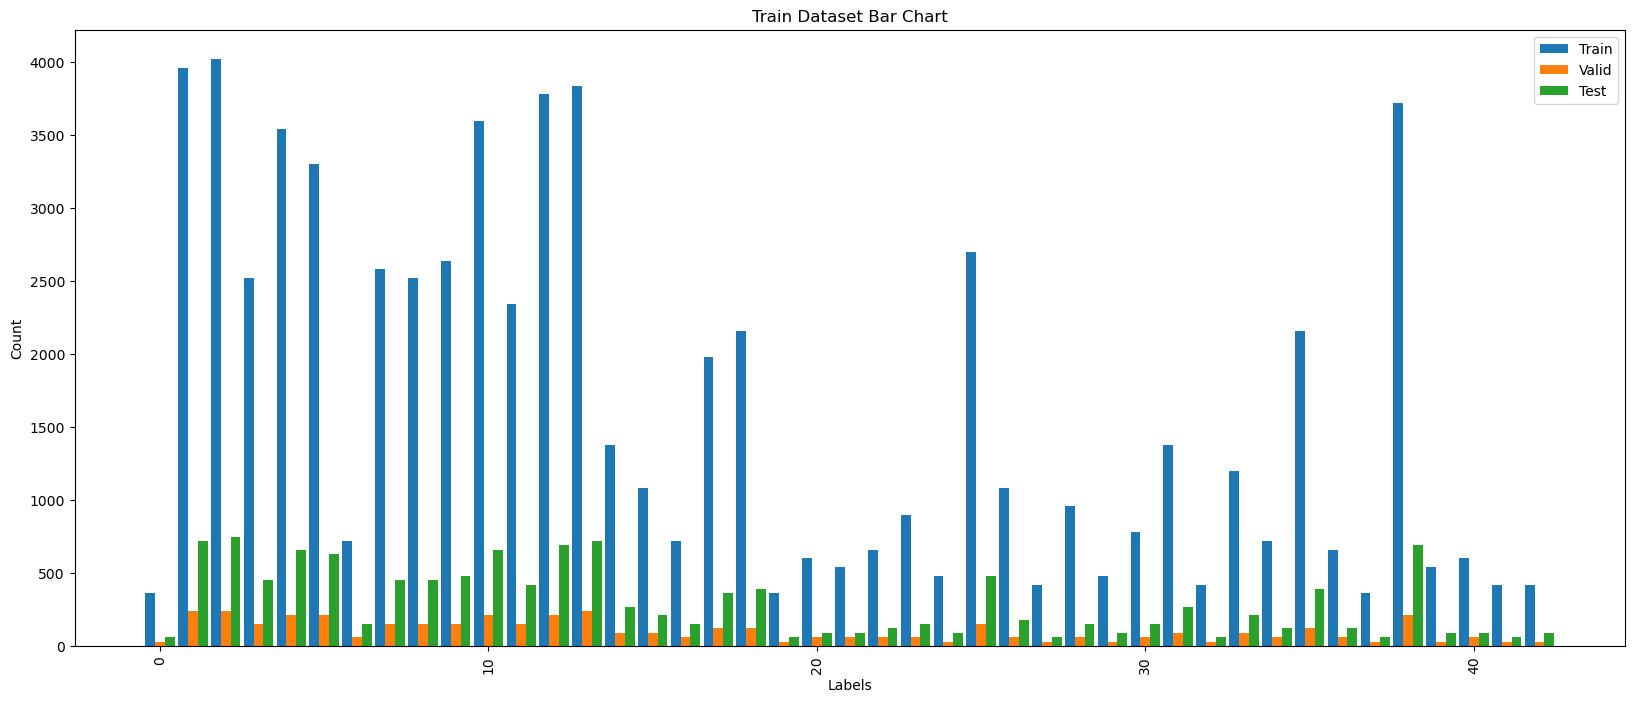

In [10]:
#n_unique, counts = np.unique(y_train, return_counts=True)


plt.figure(figsize=(20, 8))
x = np.arange(int(n_unique))
width = 0.3
#fig, ax = plt.subplots()
#train_bar = ax.bar(x-width/3, train_count.values(), width)
#valid_bar = ax.bar(x, valid_count.values(), width)
#train_bar = ax.bar(x+width/3, test_count.values(), width)
plt.bar(x-width, train_count.values(), width, label="Train")
plt.bar(x, valid_count.values(), width, label="Valid")
plt.bar(x+width, test_count.values(), width, label="Test")
plt.title("Train Dataset Bar Chart")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend()
plt.show()

## Preprocesing the data

In [11]:
import cv2



def to_num(new_X):
    new_X = np.array(new_X, np.float32)
    if len(new_X.shape) <= 3:
        new_X = np.expand_dims(new_X, axis=-1)
    return new_X

def standardize(X):
    #X = X/255.0
    X = (X-total_mean)/total_std
    return X

def grayscale(X):
    new_X = []
    for img in X:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        new_X.append(gray)
    #new_X = standardize(to_num(new_X))
    return new_X

def hsl(images, layer=0):
    hued = []
    for image in images:
        transit = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        #transit = transit[:, :, layer]
        #mask = np.zeros_like(transit)
        #mask[(transit > 70) & (transit > 255)] = 1
        #hued.append(mask)
        hued.append(transit)
    #hued = standardize(to_num(hued))
    return hued

def yuv(images, layer=0):
    hued = []
    for image in images:
        transit = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        transit = transit[:, :, layer]
        #mask = np.zeros_like(transit)
        #mask[(transit > 70) & (transit > 255)] = 1
        #hued.append(mask)
        hued.append(transit)
    #hued = standardize(to_num(hued))
    return hued



#X_train = grayscale(X_train)
#X_valid = grayscale(X_valid)
#X_test = grayscale(X_test)

layer = 0

X_train = yuv(X_train, layer)
X_valid = yuv(X_valid, layer)
X_test = yuv(X_test, layer)

total_mean = np.mean(X_train)
total_std = np.std(X_train)

X_train = standardize(to_num(X_train))
X_valid =  standardize(to_num(X_valid))
X_test =  standardize(to_num(X_test))

In [12]:
print(X_train.shape)

(69598, 32, 32, 1)


## Parameters

In [13]:
learning_rate = 0.001
epochs = 40
batch_size = 64
input_depth = X_train.shape[-1]
steps_per_epoch = int(np.ceil(n_train / batch_size))
s = 1

In [14]:
from tensorflow.keras import layers
X_train = np.astype(X_train, np.float32)


aug = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.03),          # ~10 degrees
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment_image(image, label):
    image = aug(image)
    return image, label

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#train_data = train_data.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(n_train).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1764638251.839600   32715 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


# Step 2: Building Model

In [90]:
class CNN_Model(tf.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()

        mu=0
        sigma=0.001
        depthc1 = 16#12
        depthc2 = 32#24
        depthc3 = 64#32
        depthc4 = 128#64
        depthc5 = 256
        depthf1 = 1024
        depthf2 = 180
        depthf3 = 43
        self.momentum = 0.9
        self.epsilon = 1e-5
        
        self.wc1 = tf.Variable(tf.random.normal([3, 3, input_depth, depthc1], mean=mu, stddev=sigma), name="weightc1", trainable=True)
        self.bc1 = tf.Variable(tf.zeros([depthc1]), name="biasc1", trainable=True)
        self.g1 = tf.Variable(tf.ones([depthc1]), name="g1", trainable=True)
        self.b1  = tf.Variable(tf.zeros(depthc1), name="b1", trainable=True)
        self.mm1 = tf.Variable(tf.ones([depthc1]), name="mm1", trainable=False)
        self.mv1 = tf.Variable(tf.zeros(depthc1), name="mv1", trainable=False)

        self.wc2 = tf.Variable(tf.random.normal([3, 3, depthc1, depthc2], mean=mu, stddev=sigma), name="weightc2", trainable=True)
        self.bc2 = tf.Variable(tf.zeros([depthc2]), name="biasc2", trainable=True)
        self.g2 = tf.Variable(tf.ones([depthc2]), name="g2", trainable=True)
        self.b2  = tf.Variable(tf.zeros([depthc2]), name="b2", trainable=True)
        self.mm2 = tf.Variable(tf.ones([depthc2]), name="mm2", trainable=False)
        self.mv2 = tf.Variable(tf.zeros(depthc2), name="mv2", trainable=False)

        self.wc3 = tf.Variable(tf.random.normal([3, 3, depthc2, depthc3], mean=mu, stddev=sigma), name="weightc3", trainable=True)
        self.bc3 = tf.Variable(tf.zeros([depthc3]), name="biasc3", trainable=True)
        self.g3 = tf.Variable(tf.ones([depthc3]), name="g3", trainable=True)
        self.b3  = tf.Variable(tf.zeros([depthc3]), name="b3", trainable=True)
        self.mm3 = tf.Variable(tf.ones([depthc3]), name="mm3", trainable=False)
        self.mv3 = tf.Variable(tf.zeros(depthc3), name="mv3", trainable=False)

        self.wc4 = tf.Variable(tf.random.normal([3, 3, depthc3, depthc4], mean=mu, stddev=sigma), name="weightc4", trainable=True)
        self.bc4 = tf.Variable(tf.zeros([depthc4]), name="biasc4", trainable=True)
        self.g4 = tf.Variable(tf.ones([depthc4]), name="g4", trainable=True)
        self.b4  = tf.Variable(tf.zeros([depthc4]), name="b4", trainable=True)
        self.mm4 = tf.Variable(tf.ones([depthc4]), name="mm4", trainable=False)
        self.mv4 = tf.Variable(tf.zeros(depthc4), name="mv4", trainable=False)

        self.wc5 = tf.Variable(tf.random.normal([3, 3, depthc4, depthc5], mean=mu, stddev=sigma), name="weightc5", trainable=True)
        self.bc5 = tf.Variable(tf.zeros([depthc5]), name="biasc5", trainable=True)
        self.g5 = tf.Variable(tf.ones([depthc5]), name="g5", trainable=True)
        self.b5  = tf.Variable(tf.zeros([depthc5]), name="b5", trainable=True)
        self.mm5 = tf.Variable(tf.ones([depthc5]), name="mm5", trainable=False)
        self.mv5 = tf.Variable(tf.zeros(depthc5), name="mv5", trainable=False)


        self.wfc1 = tf.Variable(tf.random.normal([6*6*(depthc5), depthf1], mean=mu, stddev=sigma), name="weight1", trainable=True)
        self.bfc1 = tf.Variable(tf.zeros([depthf1]), name="bias1", trainable=True)
        self.g_f1 = tf.Variable(tf.ones([depthf1]), name="g_f1", trainable=True)
        self.bc_f1  = tf.Variable(tf.zeros([depthf1]), name="b_f1", trainable=True)
        self.mm_f1 = tf.Variable(tf.ones([depthf1]), name="mm_f1", trainable=False)
        self.mv_f1 = tf.Variable(tf.zeros(depthf1), name="mv_f1", trainable=False)

        self.wfc2 = tf.Variable(tf.random.normal([depthf1, depthf2], mean=mu, stddev=sigma), name="weight4", trainable=True)
        self.bfc2 = tf.Variable(tf.zeros([depthf2]), name="bias4", trainable=True)
        self.g_f2 = tf.Variable(tf.ones([depthf2]), name="g_f2", trainable=True)
        self.bc_f2  = tf.Variable(tf.zeros([depthf2]), name="b_f2", trainable=True)
        self.mm_f2 = tf.Variable(tf.ones([depthf2]), name="mm_f2", trainable=False)
        self.mv_f2 = tf.Variable(tf.zeros(depthf2), name="mv_f2", trainable=False)

        self.wfc3 = tf.Variable(tf.random.normal([depthf2, depthf3], mean=mu, stddev=sigma), name="weight2", trainable=True)
        self.bfc3 = tf.Variable(tf.zeros([depthf3]), name="bias2", trainable=True)



    def batch_norm_train(self, conv, batch_b, batch_g, mm=0, mv=0.01, axes=[0]):

        batch_mean, batch_var = tf.nn.moments(conv, axes=axes)

        mm.assign(self.momentum * mm + (1 - self.momentum) * batch_mean)
        mv.assign(self.momentum * mv + (1 - self.momentum) * batch_var)
        conv = tf.nn.batch_normalization(conv, batch_mean, batch_var, batch_b, batch_g, self.epsilon)
        return conv


    def batch_norm_inf(self, conv, batch_b, batch_g, mm=0, mv=0.01):
        conv = tf.nn.batch_normalization(conv, mm, mv, batch_b, batch_g, self.epsilon)
        return conv
    

    def conv2d(self, feed_data, feed_weight, feed_bias, stride=2, padding="VALID", batch_b=1, batch_g=0, is_training=False, mm=0, mv=0.01):
        conv = tf.nn.conv2d(
            feed_data,
            feed_weight,
            strides=[1, stride, stride, 1],
            padding = padding
        )
        conv = tf.nn.bias_add(conv, feed_bias)
        if is_training:
            conv = self.batch_norm_train(conv, batch_b, batch_g, mm, mv, axes=[0, 1, 2])
        else:
            conv = self.batch_norm_train(conv, batch_b, batch_g, mm, mv)
        conv = tf.nn.relu(conv)
        return conv


    def maxpool2d(self, feed_data, k=2, s=2):
        max_pool = tf.nn.max_pool(
            feed_data,
            ksize=[1, k, k, 1],
            strides=[1, s, s, 1],
            padding = "SAME"
        )
        return max_pool

        
    def __call__(self, x, is_training=False, return_activations=False):

        """
        Layer 1: 
        5 by 5 d12 + 1 by 1 d12
        max pool
        Layer 2: 
        5 by 5 + 3 by 3 + 1 by 1
        max_pool
        Layer 3: 
        Layer 4: 
        Layer 5: 
        
        """
        activations = {}

        
        #Block 1
        conv1 = self.conv2d(x, self.wc1, self.bc1, stride=1, padding="SAME", batch_b=self.b1, batch_g=self.g1, is_training=is_training, mm=self.mv1, mv=self.mv1)
        activations["conv1_1"] = conv1
        conv2 = self.conv2d(conv1, self.wc2, self.bc2, stride=1, batch_b=self.b2, batch_g=self.g2, is_training=is_training, mm=self.mv2, mv=self.mv2, padding="SAME")
        activations["conv1_2"] = conv2
        conv3 = self.maxpool2d(conv2, k=2)
        if is_training:
            conv3 = tf.nn.dropout(conv3, rate=0.1)
        activations["conv1"] = conv3

        
        #conv1b1 = self.conv2d(conv3, self.wc5, self.bc5, stride=1, is_training=is_training, mm=self.mv5, mv=self.mv5, batch_b=self.b5, batch_g=self.g5)
        #activations["conv3"] = conv1b1


        # Block 2
        conv4 = self.conv2d(conv3, self.wc3, self.bc3, stride=1, padding="SAME", batch_b=self.b3, batch_g=self.g3, is_training=is_training, mm=self.mv3, mv=self.mv3)
        activations["conv2_1"] = conv4
        conv5 = self.conv2d(conv4, self.wc4, self.bc4, stride=1, batch_b=self.b4, batch_g=self.g4, is_training=is_training, mm=self.mv4, mv=self.mv4, padding="SAME")
        activations["conv2_2"] = conv5
        conv6 = self.maxpool2d(conv5, k=2)
        if is_training:
            conv6 = tf.nn.dropout(conv6, rate=0.2)
        activations["conv2"] = conv6


        # Block 3
        conv7 = self.conv2d(conv6, self.wc5, self.bc5, stride=1, batch_b=self.b5, batch_g=self.g5, is_training=is_training, mm=self.mv5, mv=self.mv5)#, padding="SAME")
        activations["conv7"] = conv7
        if is_training:
            conv7 = tf.nn.dropout(conv7, rate=0.3)



        flatten = tf.reshape(conv7, [-1, self.wfc1.get_shape().as_list()[0]])
        
        fc1 = tf.nn.bias_add(tf.matmul(flatten, self.wfc1), self.bfc1)
        #fc1 = self.batch_norm_train(conv, batch_b=self.b_f1, batch_g=self.g_f1, mm=self.mm_f1, mv=self.mv_f1)
        fc1 = tf.nn.relu(fc1)
        if is_training:
            fc1 = tf.nn.dropout(fc1, rate=0.6)

        fc2 = tf.nn.bias_add(tf.matmul(fc1, self.wfc2), self.bfc2)
        #fc1 = self.batch_norm_train(conv, batch_b=self.b_f1, batch_g=self.g_f1, mm=self.mm_f1, mv=self.mv_f1)
        fc2 = tf.nn.relu(fc2) 
        if is_training:
            fc2 = tf.nn.dropout(fc2, rate=0.5)

        out = tf.nn.bias_add(tf.matmul(fc2, self.wfc3), self.bfc3)

        if return_activations:
            return out, activations


        return out

In [91]:
model = CNN_Model()
optimizer = tf.optimizers.Adam(learning_rate)

## Defining Helper Functions

In [92]:
def cross_entropy(logits, labels):
    labels = tf.cast(labels, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return tf.reduce_mean(loss)

def accuracy(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(labels, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def run_optimization(batch_X, batch_Y):
    with tf.GradientTape() as g:
        logit = model(batch_X, is_training=True)
        t_loss = cross_entropy(logit, batch_Y)

    gradients = g.gradient(t_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [93]:
import shutil


ckpt_dir = "./ckpt"
checkpoint = tf.train.Checkpoint(step=tf.Variable(1), model=model)#, optimizer=optimizer)

from_scratch = 1

if from_scratch:
    try:
        shutil.rmtree("./ckpt")
        print("Checkpoint Deleted")
    except FileNotFoundError:
        print("Path does not exist")
    save_loss = float("inf")
else:
    s = 5 # Last saved training stop
    checkpoint.restore(tf.train.latest_checkpoint("./ckpt"))
    valid_logit = model(X_valid, is_training=False)
    valid_probs = tf.nn.softmax(valid_logit)
    valid_loss = cross_entropy(valid_logit, y_valid)
    valid_accuracy = accuracy(valid_probs, y_valid)
    save_loss = valid_loss
    print(f"Valid loss {valid_loss}, Valid accuracy {valid_accuracy}")

manager = tf.train.CheckpointManager(checkpoint, "./ckpt/", max_to_keep=3)


Checkpoint Deleted


In [ ]:
for epoch in range(s, epochs+1): 
    for steps, (batch_X, batch_Y) in enumerate(train_data.take(steps_per_epoch), 1):
        run_optimization(batch_X, batch_Y)

    train_logit = model(batch_X, is_training=True)
    train_probs = tf.nn.softmax(train_logit)
    train_loss = cross_entropy(train_logit, batch_Y)
    train_accuracy = accuracy(train_probs, batch_Y)

    valid_logit = model(X_valid, is_training=False)
    valid_probs = tf.nn.softmax(valid_logit)
    valid_loss = cross_entropy(valid_logit, y_valid)
    valid_accuracy = accuracy(valid_probs, y_valid)

    if valid_loss < save_loss:
        save_loss = valid_loss
        saved = manager.save()
        print(f"Model Saved to {saved}")
        

    #if epoch > 15:
    #new_learning_rate = learning_rate / (epoch * 0.5)
    #optimizer.learning_rate.assign(new_learning_rate)

    print(f"Epoch {epoch}, train_loss {train_loss}, train_accuracy {train_accuracy}, valid_loss {valid_loss}, valid_accuracy {valid_accuracy}")
    

/home/forby/miniconda3/envs/sdc/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:857: UserWarning: Gradients do not exist for variables ['b_f1:0', 'b_f2:0', 'g_f1:0', 'g_f2:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


## Testing with random images

In [65]:
test_logit = model(X_test, is_training=False)
test_probs = tf.nn.softmax(test_logit)
test_loss = cross_entropy(model(X_test, is_training=True), y_test)
test_accuracy = accuracy(test_probs, y_test)

print(f"Test loss {test_loss}, Test accuracy {test_accuracy}")

2025-12-02 05:09:38.440552: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.54GiB (rounded to 1655439360)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-12-02 05:09:38.442480: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-12-02 05:09:38.443306: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 141, Chunks in use: 133. 35.2KiB allocated for chunks. 33.2KiB in use in bin. 13.0KiB client-requested in use in bin.
2025-12-02 05:09:38.443365: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 43, Chunks in use: 40. 25.8KiB allocated for chunks. 24.0KiB in use in bin. 21.6KiB client-requested in use in bin.
2025

ResourceExhaustedError: {{function_node __wrapped__Conv2D_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[12630,32,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D] name: 

## Testing on New Images

In [66]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tensorflow

In [67]:
signnames = pd.read_csv("signnames.csv")
signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [68]:
rand_test_dir = "./data/test_data/*.png"
images = glob.glob(rand_test_dir)

rand_testx = []
rand_test_name = [
    "Speed limit (80km/h)", 
     "General caution", 
     "Road work", 
     "Speed limit (70km/h)", 
     "Priority road"
]
rand_testy = []

for name in rand_test_name:
    ind = signnames.index[signnames["SignName"] == name][0]
    rand_testy.append(signnames["ClassId"][ind])

for index, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    rand_testx.append(image)


X_rand = np.array(rand_testx, np.uint8)
print(f"Number of images are {X_rand.shape}")

y_rand = np.array(rand_testy)
print(y_rand)
    


Number of images are (5, 32, 32, 3)
[ 5 18 25  4 12]


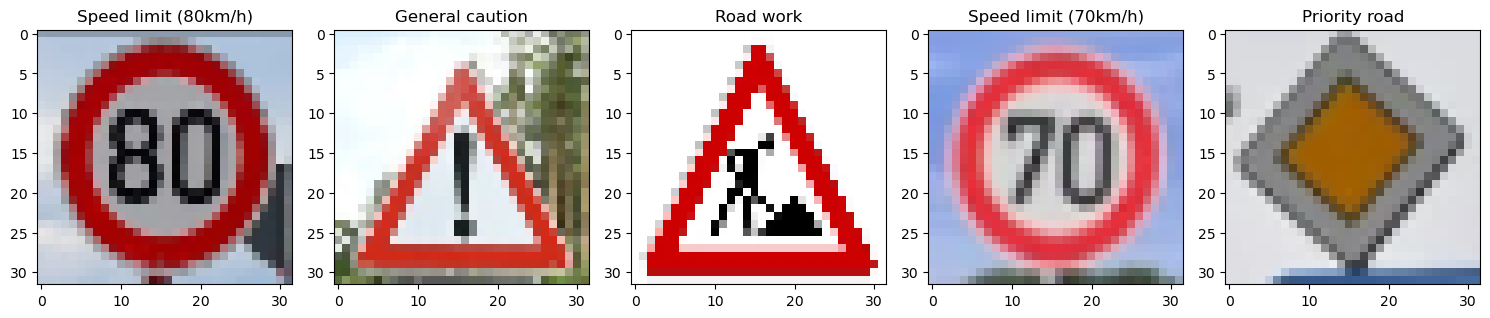

In [69]:
plt.figure(figsize=(15, 15))

for index, (image, label) in enumerate(zip(X_rand, rand_test_name)):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image)
    plt.title(label)

plt.tight_layout()
plt.show()
%matplotlib inline

In [70]:
## Cleaning Data
X_rand = yuv(X_rand, layer)
X_rand = standardize(to_num(X_rand))
print(total_mean)

80.24757435109485


In [71]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint("./ckpt"))

In [73]:
rand_logit = model(X_rand, is_training=False)
rand_probs = tf.nn.softmax(rand_logit)
rand_loss = cross_entropy(rand_logit, y_rand)
rand_accuracy = accuracy(rand_probs, y_rand)
print(f"Random data loss {rand_loss}, Random data accuracy {rand_accuracy}")

Random data loss 8.503485878463835e-05, Random data accuracy 1.0


## Outputting the top 5 Probabilites

In [74]:
tf.nn.top_k(rand_probs, k=3)

TopKV2(values=<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[9.9978036e-01, 2.1332000e-04, 6.3839984e-06],
       [9.9979478e-01, 2.0486007e-04, 3.6935120e-07],
       [1.0000000e+00, 5.6406013e-10, 1.5173980e-13],
       [1.0000000e+00, 5.7850190e-08, 7.9706703e-09],
       [1.0000000e+00, 9.2088262e-13, 5.8486874e-13]], dtype=float32)>, indices=<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[ 5,  3,  2],
       [18, 26,  4],
       [25, 20, 33],
       [ 4, 15, 18],
       [12, 15, 40]], dtype=int32)>)

## Visulaizing data

In [75]:
def outputFeatureMap(model, image_input, layer_name,
                     activation_min=None, activation_max=None, plt_num=1):

    # Forward pass and get activations
    _, activations = model(image_input, return_activations=True)

    if layer_name not in activations:
        raise ValueError(f"Layer '{layer_name}' not found. Available: {list(activations.keys())}")

    activation = activations[layer_name].numpy()
    featuremaps = activation.shape[-1]

    plt.figure(plt_num, figsize=(15, 15))

    for i in range(featuremaps):
        plt.subplot(6, 8, i + 1)
        plt.title(f'FeatureMap {i}')
        
        img = activation[0, :, :, i]

        if activation_min is not None and activation_max is not None:
            plt.imshow(img, cmap="gray",
                       vmin=activation_min, vmax=activation_max)
        elif activation_max is not None:
            plt.imshow(img, cmap="gray", vmax=activation_max)
        elif activation_min is not None:
            plt.imshow(img, cmap="gray", vmin=activation_min)
        else:
            plt.imshow(img, cmap="gray")

        plt.axis("off")

        if i == 47:
            break

    plt.tight_layout()
    plt.show()

In [83]:
img=X_rand[2]
img = np.reshape(img, (-1, img.shape[0], img.shape[1], img.shape[2]))
print(img.shape)

(1, 32, 32, 1)


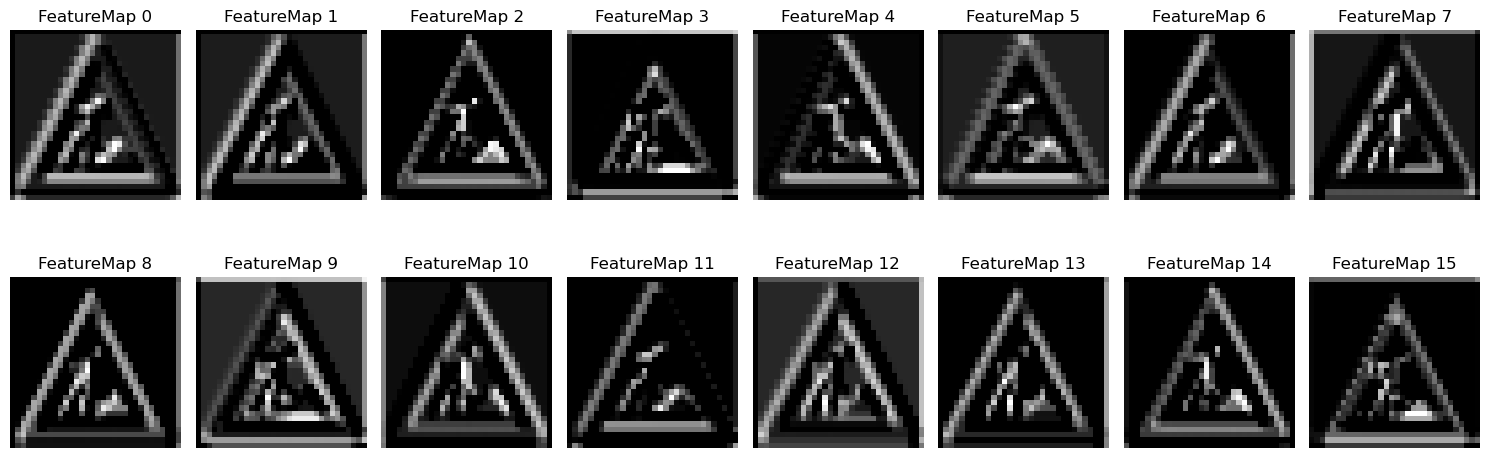

In [84]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv1_1")

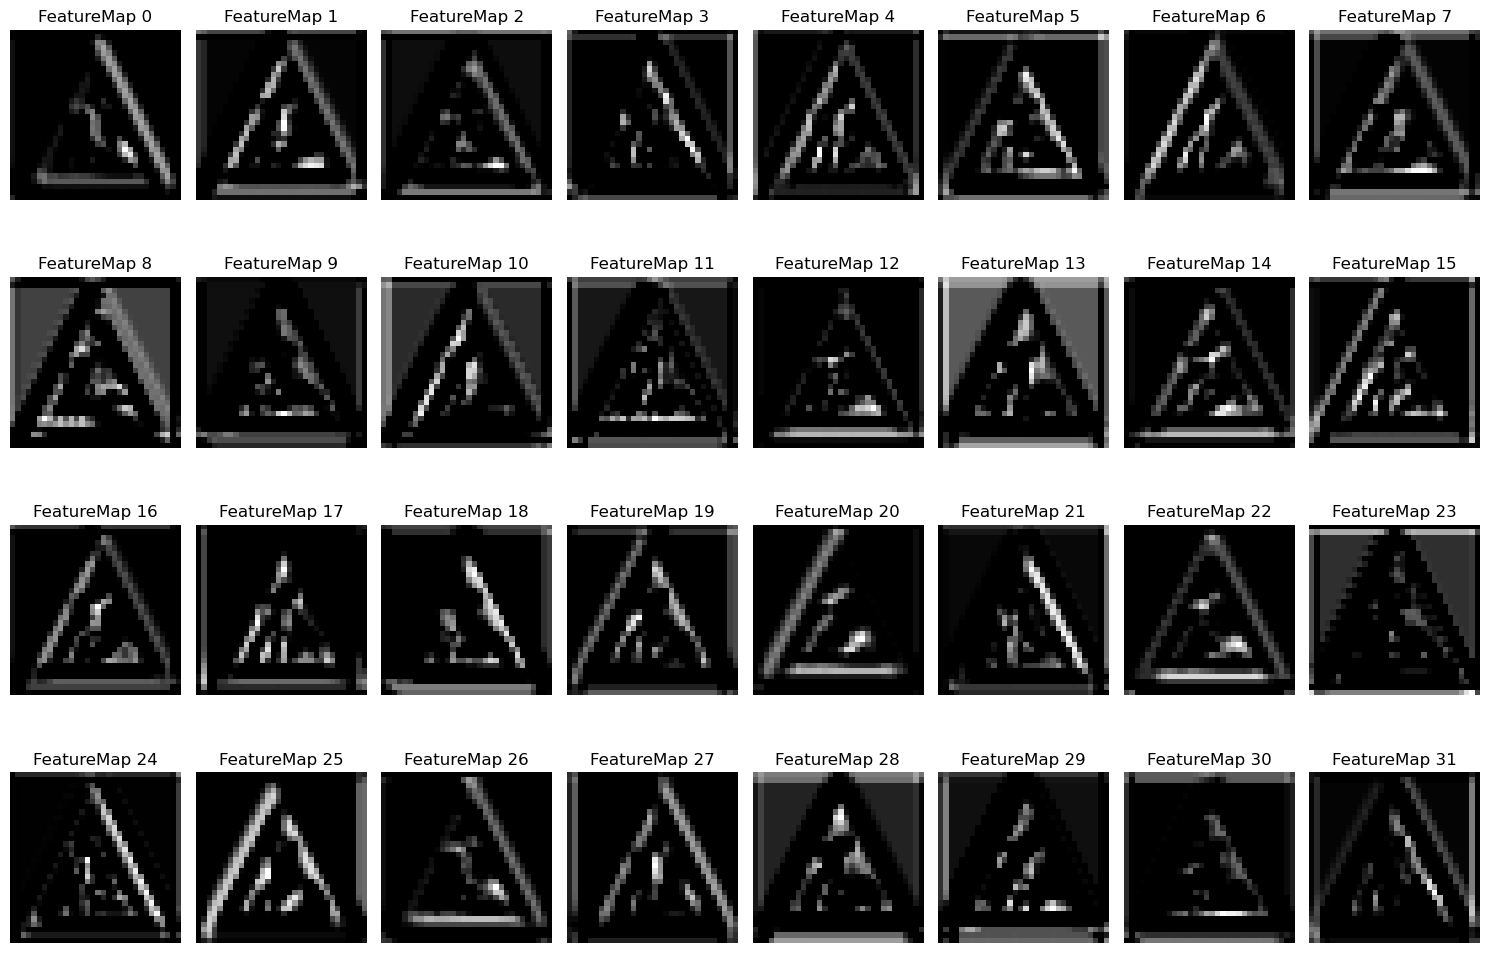

In [85]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv1_2")

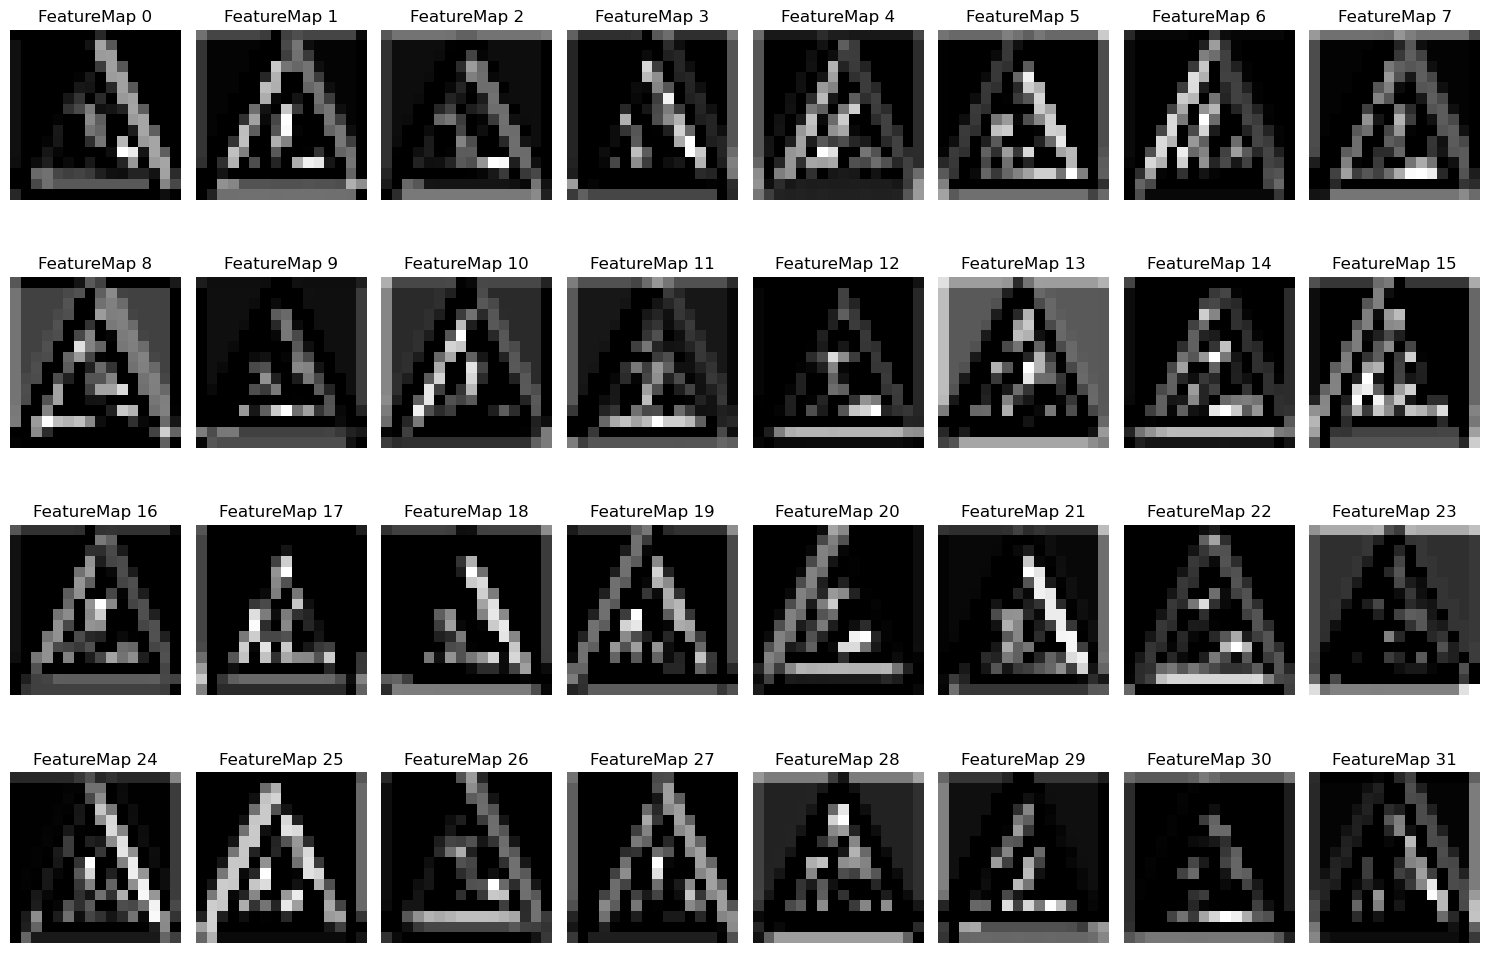

In [86]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv1")

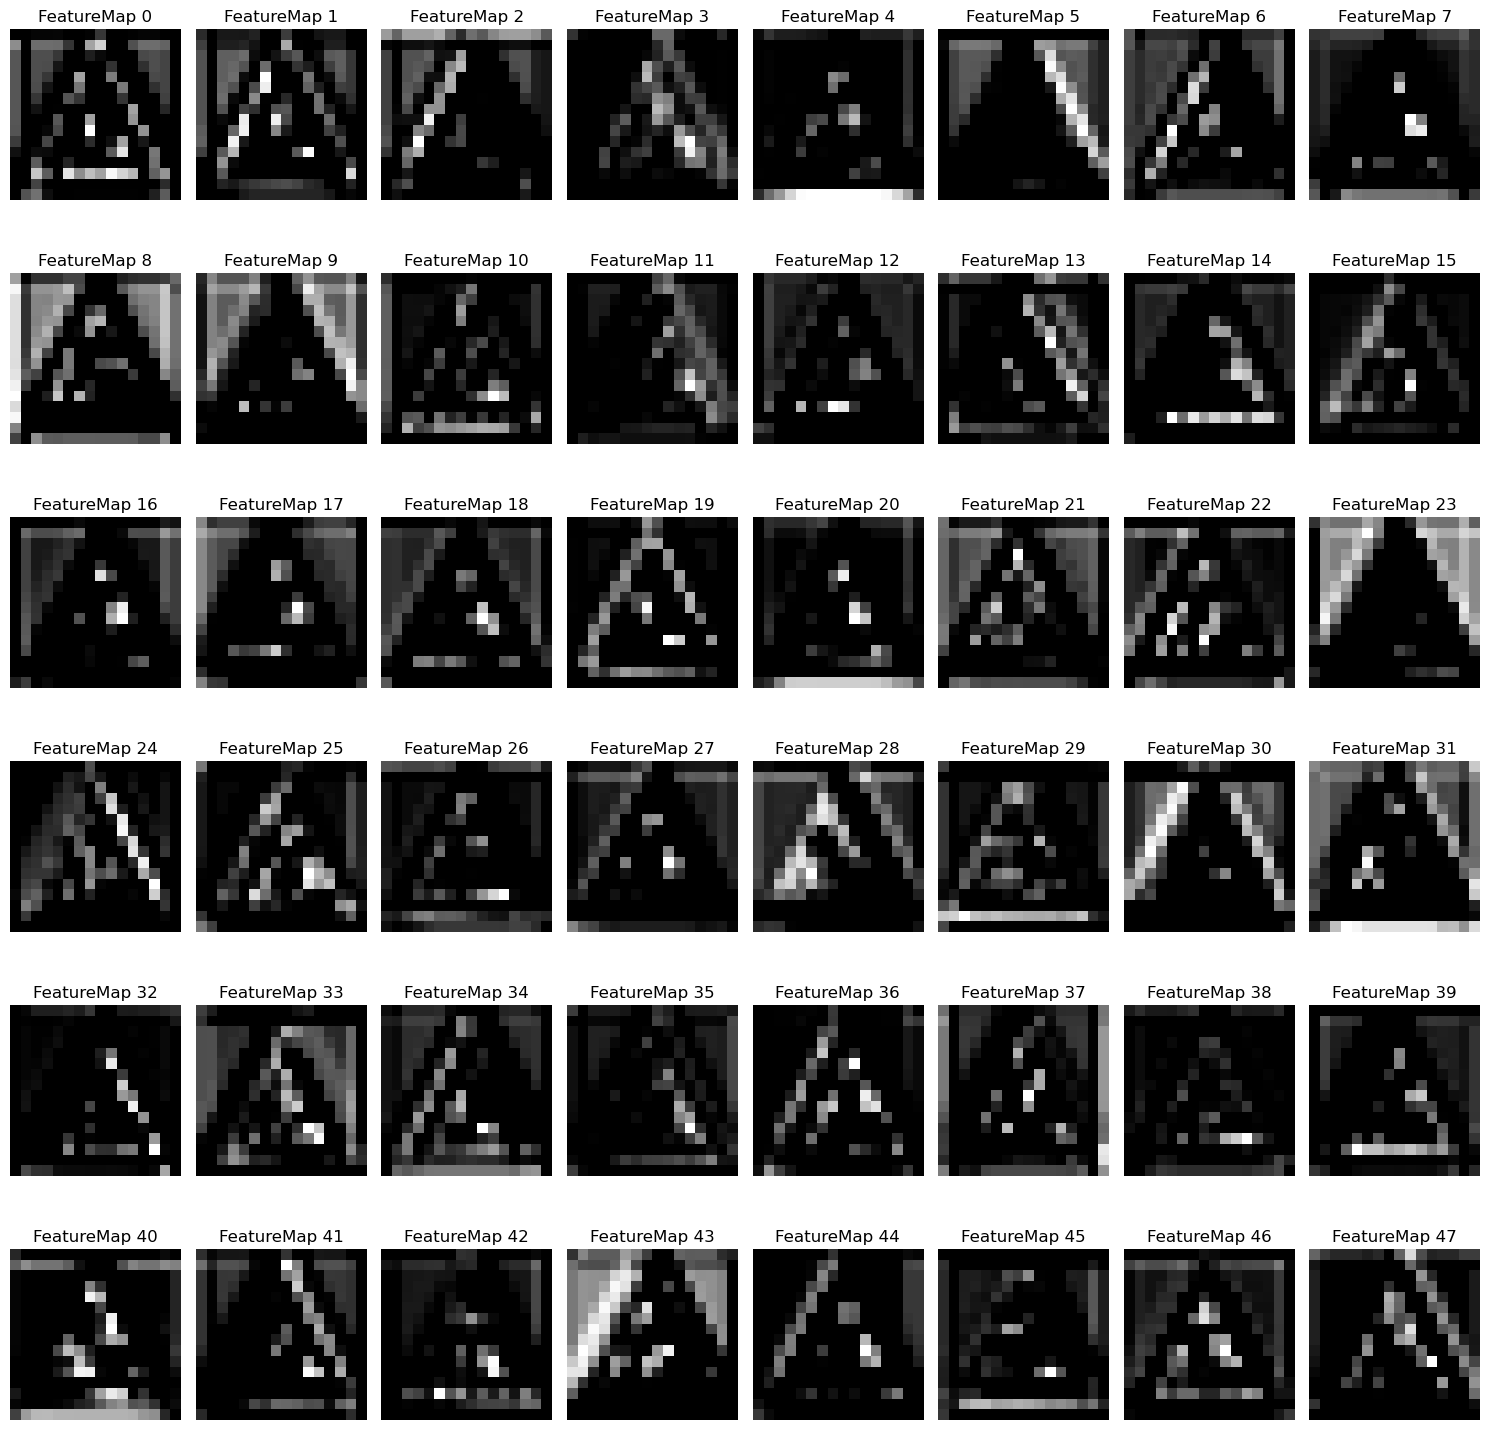

In [87]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv2_1")

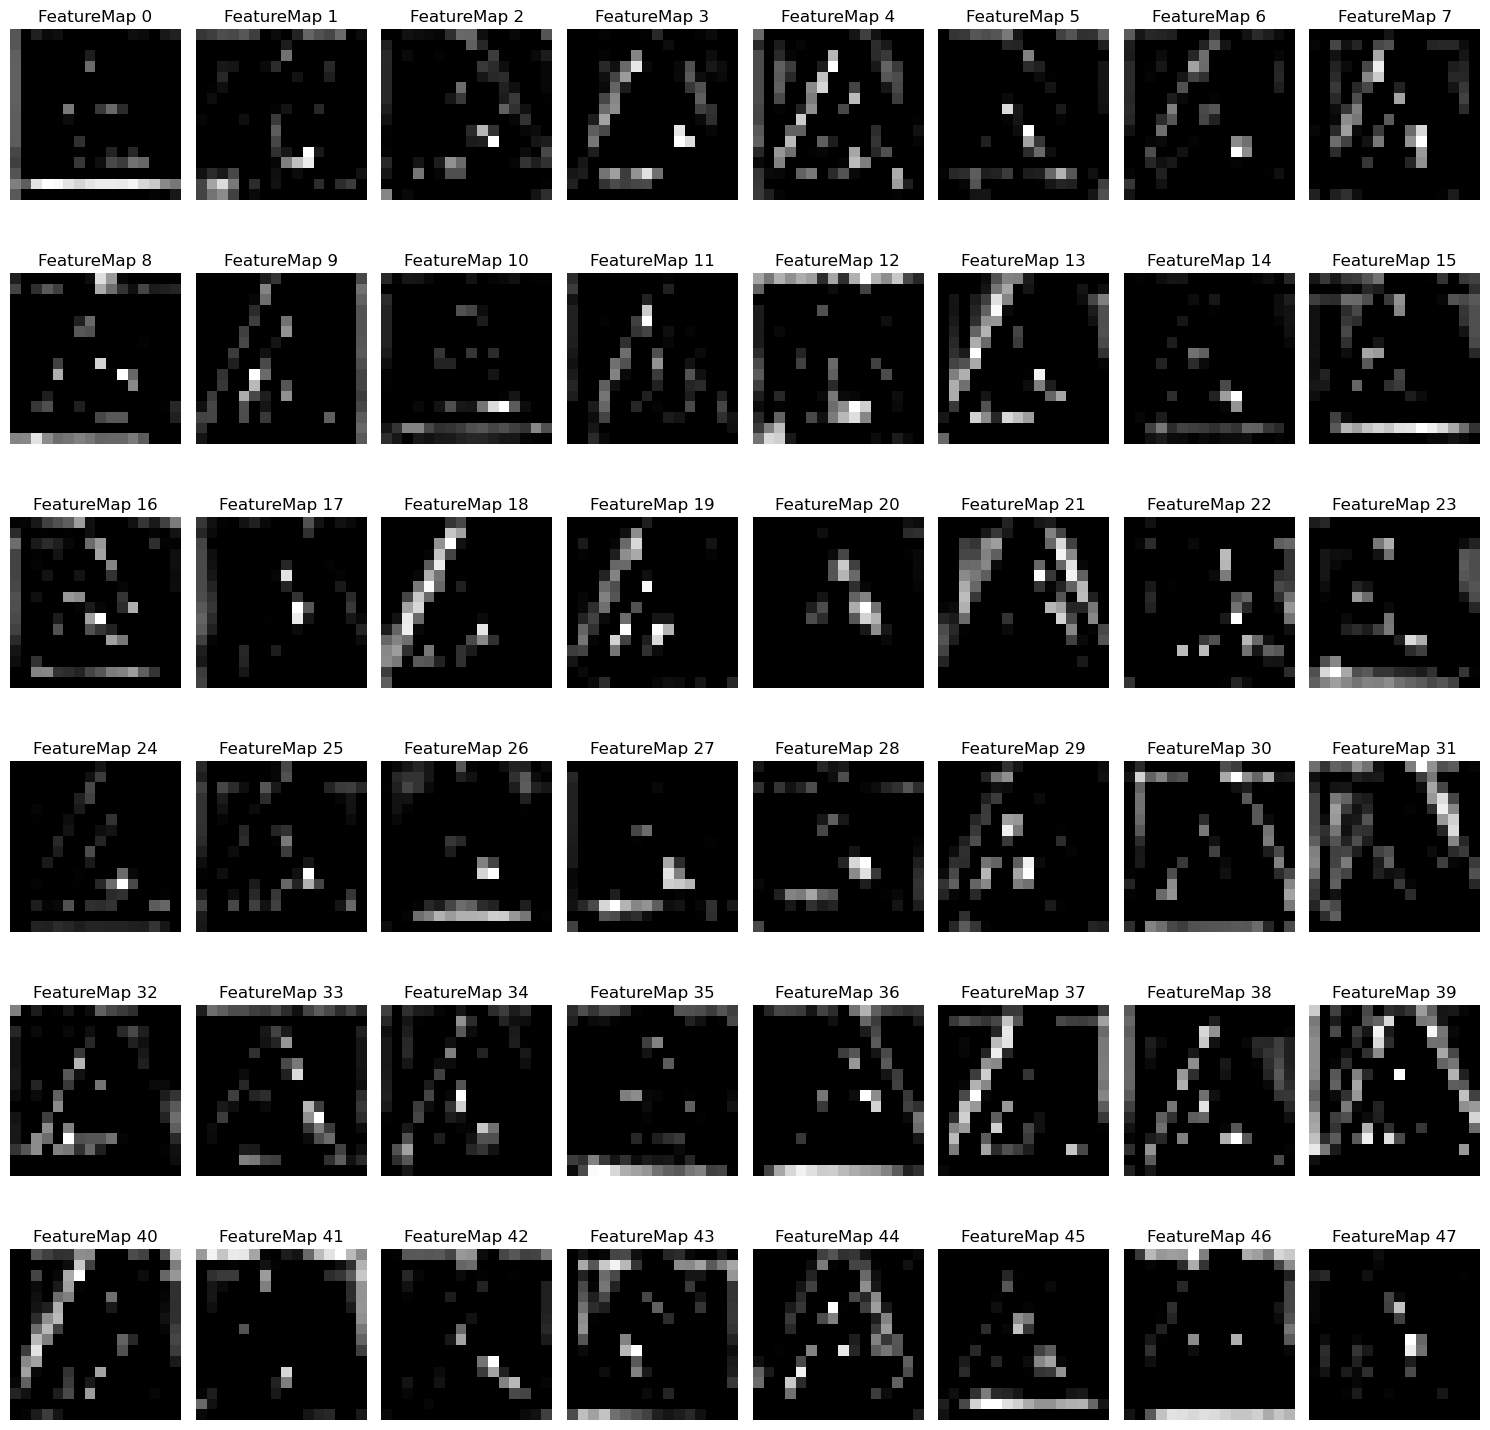

In [88]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv2_2")

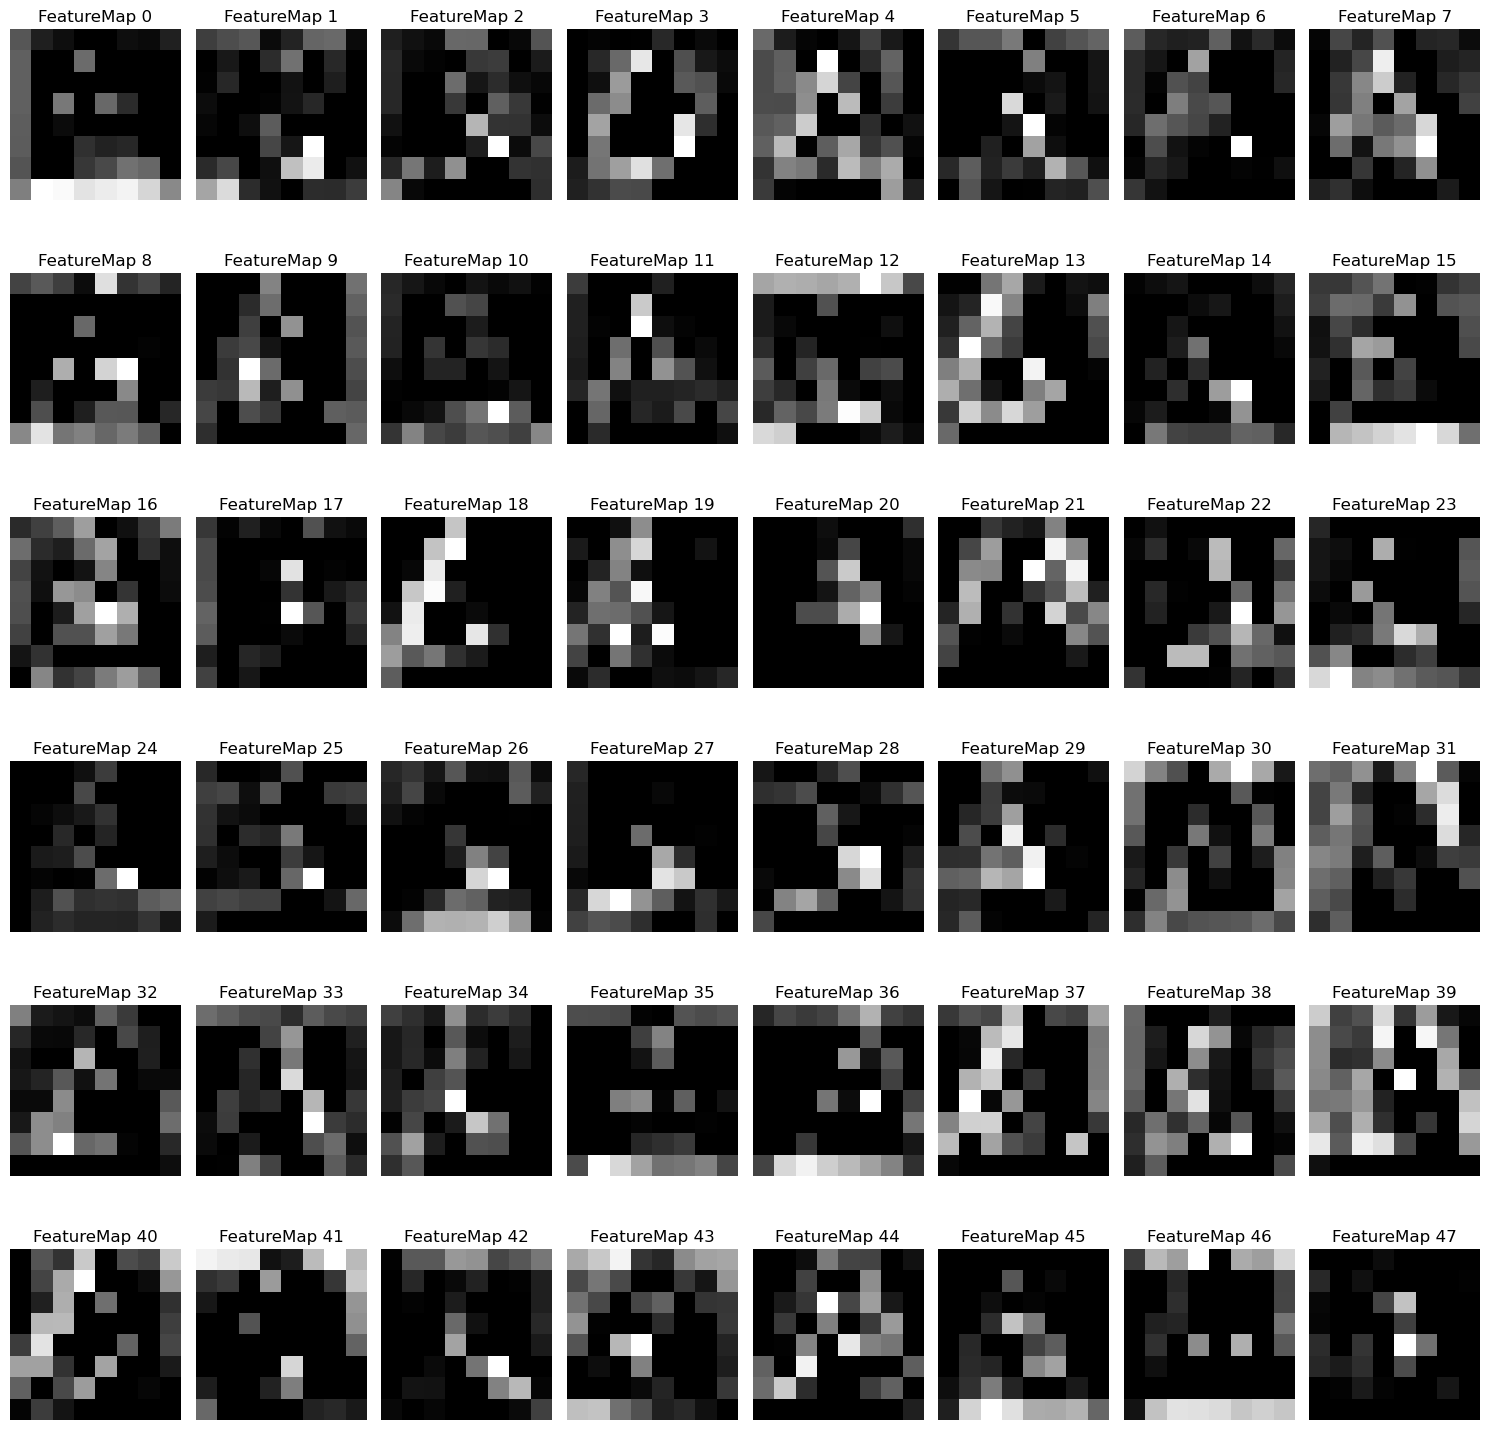

In [89]:
outputFeatureMap(model=model, 
                 image_input=img, 
                 layer_name="conv2")